In [2]:
import cv2
import numpy as np
from PIL import Image, ImageStat
from skimage import io, color, measure
import pandas as pd
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

In [6]:
airforce = pd.read_csv('./Airfocre_tot.csv',encoding='cp949')

In [7]:
airforce.columns

Index(['id', 'status', 'create_date', 'name', 'keyword', 'price', 'flag_used',
       'flag_taekpo', 'flag_exchg', 'qty', 'category_id', 'image_count',
       'modified_at', 'latest_updated_at', 'description', 'category', 'name.1',
       'is_enable', 'name_kor', 'seller_birth_year', 'seller_gender',
       'buyer_birth_year', 'buyer_gender', 'uid', 'is_active', 'created_at',
       'setl_done_date', 'purchase_confirm_date', 'total_price',
       'talk_user_count', 'first_talk_date', 'sell_count',
       'register_prod_count'],
      dtype='object')

# 이미지 정보 추출

In [63]:
def analyze_image_quality(image_path):  # resolution, focus, noise, brightness
    # 이미지 로드
    image = cv2.imread(image_path)
    if image is None:
        print(f"Cannot load image: {image_path}")
        return

    # 해상도
    height, width, _ = image.shape
    resolution = (width, height)
    print(f"Resolution: {resolution}")

    # 초점 (Laplacian 방법으로 측정)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    print(f"Focus (Laplacian variance): {laplacian_var}")

    # 노이즈 (GaussianBlur 방법으로 측정)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    noise = cv2.Laplacian(blur, cv2.CV_64F).var()
    print(f"Noise (GaussianBlur variance): {noise}")

    # 조명 (밝기)
    pil_image = Image.open(image_path)
    stat = ImageStat.Stat(pil_image)
    brightness = stat.mean[0]
    print(f"Brightness: {brightness}")

    return_dic = {
        'resolution': resolution,
        'focus': laplacian_var,
        'noise': noise,
        'brightness': brightness
    }

    return return_dic

def analyze_image_composition(image_path): # subject_centroid, distance_from_center, largest_region_area, subject_cropped
    # 이미지 로드
    image = cv2.imread(image_path)
    if image is None:
        print(f"Cannot load image: {image_path}")
        return

    height, width, _ = image.shape
    center_x, center_y = width // 2, height // 2

    # 그레이스케일 변환 및 이진화
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 레이블링을 통한 영역 분리
    labeled_image = label(binary)
    regions = regionprops(labeled_image)

    if regions:
        largest_region = max(regions, key=lambda r: r.area)
        subject_centroid = largest_region.centroid

        # 이미지 크기 대비 퍼센티지로 변환
        centroid_x_percent = ((subject_centroid[1] - center_x) / width) 
        centroid_y_percent = ((subject_centroid[0] - center_y) / height) 
        subject_centroid_percent = (centroid_x_percent, centroid_y_percent)

        # 이미지 대각선 길이로 정규화된 중심에서의 거리 계산
        diagonal_length = np.sqrt(width ** 2 + height ** 2)
        distance_from_center = np.sqrt((subject_centroid[1] - center_x) ** 2 + (subject_centroid[0] - center_y) ** 2) / diagonal_length
        print(f"Subject centroid: {subject_centroid_percent}")
        print(f"Normalized distance from center: {distance_from_center}")

        # 주요 피사체가 차지하는 비중 계산
        image_area = height * width
        subject_area_percent = (largest_region.area / image_area)
        print(f"Subject area percent: {subject_area_percent}")

        # 피사체가 잘렸는지 확인 (중심점 기준으로 판단)
        bounding_box = largest_region.bbox  # (min_row, min_col, max_row, max_col)
        cropped = (
            bounding_box[0] <= 0 or
            bounding_box[1] <= 0 or
            bounding_box[2] >= height or
            bounding_box[3] >= width
        )
        print(f"Subject cropped: {cropped}")

        return_dic = {
            'subject_centroid': subject_centroid_percent,
            'distance_from_center': distance_from_center,
            'largest_region_area': subject_area_percent,
            'subject_cropped': 1 if cropped else 0
        }

        return return_dic
    else:
        print("No subject found")
        return None


def analyze_image_colors(image_path):  # hue, mean
    # 이미지 로드
    image = io.imread(image_path)
    if image is None:
        print(f"Cannot load image: {image_path}")
        return

    # 색상 (HSV 히스토그램 분석)
    hsv_image = color.rgb2hsv(image)
    hue_hist = np.histogram(hsv_image[:, :, 0], bins=50, range=(0, 1))
    print(f"Hue histogram: {hue_hist}")

    # 감성 전달 (평균 색상 계산)
    mean_color = np.mean(image, axis=(0, 1))
    print(f"Mean color: {mean_color}")

    return_dic = {
        'hue': hue_hist,
        'mean': mean_color
    }

    return return_dic

In [85]:
# 이미지 파일 경로
file_path = '../data/airforce_tot_classification/Full'
image_path = file_path + '/3df48473e6ef3a72f4e205bc04b856ef_1.jpg'

In [69]:
print("Analyzing Image Quality...")
analyze_image_quality(image_path)
print("\nAnalyzing Image Composition...")
analyze_image_composition(image_path)
# print("\nAnalyzing Image Colors...")
# analyze_image_colors(image_path)

Analyzing Image Quality...
Resolution: (900, 1200)
Focus (Laplacian variance): 3443.1203004802446
Noise (GaussianBlur variance): 159.78838788733793
Brightness: 147.88983148148148

Analyzing Image Composition...
Subject centroid: (-0.01112563949760853, -0.13835889063743384)
Normalized distance from center: 0.11088822130105953
Subject area percent: 0.43245833333333333
Subject cropped: True


{'subject_centroid': (-0.01112563949760853, -0.13835889063743384),
 'distance_from_center': 0.11088822130105953,
 'largest_region_area': 0.43245833333333333,
 'subject_cropped': 1}

# largest region 추출 확인

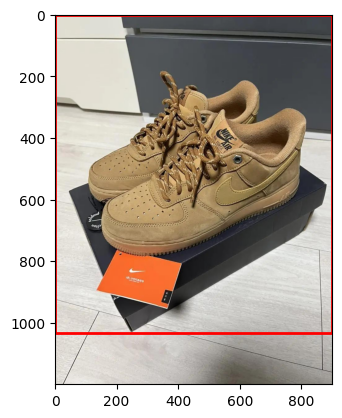

In [86]:
image = cv2.imread(image_path)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

labeled_image = label(binary)
regions = regionprops(labeled_image)

if regions:
    largest_region = max(regions, key=lambda r: r.area)

    # 주요 피사체 영역 시각화
    min_row, min_col, max_row, max_col = largest_region.bbox
    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    rect = plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                            edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(rect)
    plt.show()
else:
    print("No subject found")

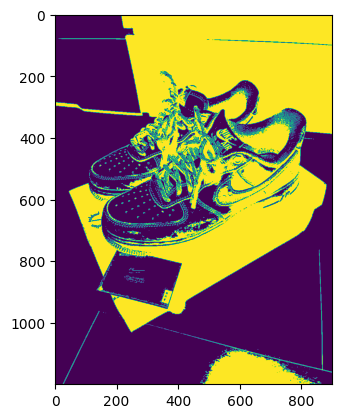

In [87]:
plt.imshow(binary)